In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from fastapi import FastAPI
import uvicorn

In [2]:
sales_train = pd.read_csv("sales_train.csv")
items = pd.read_csv("items.csv")
shops = pd.read_csv("shops.csv")
item_categories = pd.read_csv("item_categories.csv")
test = pd.read_csv("test.csv")

In [3]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')
sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
sales_monthly.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

In [4]:
sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
sales_monthly = sales_monthly.merge(shops[['shop_id']], on='shop_id', how='left')

In [5]:
monthly_total = sales_monthly.groupby('date_block_num')['item_cnt_month'].sum()
plt.figure(figsize=(10, 6))
plt.plot(monthly_total.index, monthly_total.values)
plt.title("Total Monthly Sales Over Time")
plt.xlabel("Date Block Number (0 = Jan 2013, 33 = Oct 2015)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.savefig('sales_trend.png')
plt.close()

In [6]:
Q1 = sales_monthly['item_cnt_month'].quantile(0.25)
Q3 = sales_monthly['item_cnt_month'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (sales_monthly['item_cnt_month'] >= Q1 - 1.5 * IQR) & (sales_monthly['item_cnt_month'] <= Q3 + 1.5 * IQR)
sales_monthly = sales_monthly[outlier_mask]

In [7]:
date_range = range(0, 34)
shop_ids = sales_train['shop_id'].unique()
item_ids = sales_train['item_id'].unique()

In [8]:
grid = []
for date_block in date_range:
    for shop in shop_ids:
        for item in item_ids:
            grid.append([date_block, shop, item])
grid = pd.DataFrame(grid, columns=['date_block_num', 'shop_id', 'item_id'])

print(grid)

          date_block_num  shop_id  item_id
0                      0       59    22154
1                      0       59     2552
2                      0       59     2554
3                      0       59     2555
4                      0       59     2564
...                  ...      ...      ...
44486275              33       36     8428
44486276              33       36     7903
44486277              33       36     7610
44486278              33       36     7635
44486279              33       36     7640

[44486280 rows x 3 columns]


In [9]:
sales_monthly = grid.merge(sales_monthly, on=['date_block_num', 'shop_id', 'item_id'], how='left').fillna(0)
sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

In [10]:
for lag in [1, 2, 3]:
    shifted = sales_monthly.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    sales_monthly[f'lag_{lag}'] = shifted

In [11]:
# sales_train['date'] = pd.to_datetime(sales_train['date'], format='%d.%m.%Y')

# sales_monthly = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index()
# sales_monthly.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)

# sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
# sales_monthly = sales_monthly.merge(shops[['shop_id']], on='shop_id', how='left')

# print("Aggregated Monthly Sales Data:")
# display(sales_monthly.head())

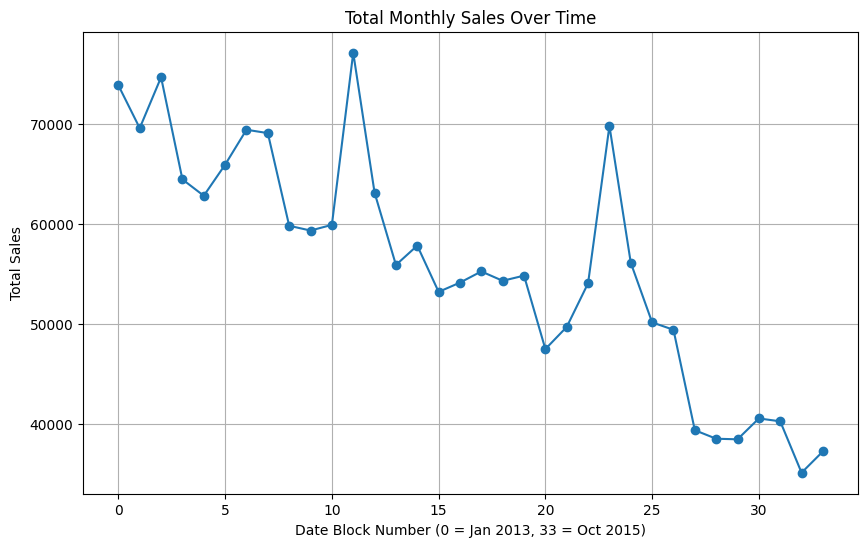

In [12]:
monthly_total = sales_monthly.groupby('date_block_num')['item_cnt_month'].sum()

plt.figure(figsize=(10, 6))
plt.plot(monthly_total.index, monthly_total.values, marker='o')
plt.title("Total Monthly Sales Over Time")
plt.xlabel("Date Block Number (0 = Jan 2013, 33 = Oct 2015)")
plt.ylabel("Total Sales")
plt.grid(True)
plt.savefig('sales_trend.png')
plt.show()

In [13]:
Q1 = sales_monthly['item_cnt_month'].quantile(0.25)
Q3 = sales_monthly['item_cnt_month'].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (sales_monthly['item_cnt_month'] >= Q1 - 1.5 * IQR) & (sales_monthly['item_cnt_month'] <= Q3 + 1.5 * IQR)

print(f"Number of outliers: {len(sales_monthly) - outlier_mask.sum()}")

sales_monthly = sales_monthly[outlier_mask]

print("Stats after removing outliers:")
display(sales_monthly['item_cnt_month'].describe())

Number of outliers: 1427554
Stats after removing outliers:


count    43058726.0
mean            0.0
std             0.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max             0.0
Name: item_cnt_month, dtype: float64

In [ ]:
date_range = range(0, 34)

shop_ids = sales_train['shop_id'].unique()
item_ids = sales_train['item_id'].unique()

grid = []
for date_block in date_range:
    for shop in shop_ids:
        for item in item_ids:
            grid.append([date_block, shop, item])

grid = pd.DataFrame(grid, columns=['date_block_num', 'shop_id', 'item_id'])

print(f"Grid shape: {grid.shape}")
display(grid.head())

In [ ]:
sales_monthly = grid.merge(sales_monthly[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_category_id', 'lag_1', 'lag_2', 'lag_3']], 
                          on=['date_block_num', 'shop_id', 'item_id'], 
                          how='left')

sales_monthly['item_cnt_month'] = sales_monthly['item_cnt_month'].fillna(0)
sales_monthly[['lag_1', 'lag_2', 'lag_3']] = sales_monthly[['lag_1', 'lag_2', 'lag_3']].fillna(0)

sales_monthly = sales_monthly.rename(columns={'item_category_id': 'item_category_id_temp'})
sales_monthly = sales_monthly.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

sales_monthly['item_category_id'] = sales_monthly['item_category_id'].fillna(sales_monthly['item_category_id_temp'])
sales_monthly['item_category_id'] = sales_monthly['item_category_id'].fillna(-1)  # Use -1 for unknown categories

sales_monthly = sales_monthly.drop(columns=['item_category_id_temp'])

print("Sales Monthly Data after Merging:")
display(sales_monthly.head())
print("\nMissing Values:")
display(sales_monthly.isnull().sum())

KeyError: "['item_category_id'] not in index"

In [ ]:
print("Unique Shop IDs:", sales_monthly['shop_id'].nunique())
print("Unique Item IDs:", sales_monthly['item_id'].nunique())
print("Unique Item Category IDs:", sales_monthly['item_category_id'].nunique())
print("\nData Types:")
display(sales_monthly.dtypes)

Unique Shop IDs: 60
Unique Item IDs: 21807


KeyError: 'item_category_id'

In [ ]:
for lag in [1, 2, 3]:
    shifted = sales_monthly.groupby(['shop_id', 'item_id'])['item_cnt_month'].shift(lag)
    sales_monthly[f'lag_{lag}'] = shifted

sales_monthly[['lag_1', 'lag_2', 'lag_3']] = sales_monthly[['lag_1', 'lag_2', 'lag_3']].fillna(0)

print("Sales Monthly Data with Lag Features:")
display(sales_monthly.head())

In [ ]:
sales_monthly['rolling_mean'] = sales_monthly.groupby(['shop_id', 'item_id'])['item_cnt_month'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

sales_monthly['rolling_mean'] = sales_monthly['rolling_mean'].fillna(0)

print("Sales Monthly Data with Rolling Mean:")
display(sales_monthly.head())

In [ ]:
price_data = sales_train.groupby(['date_block_num', 'shop_id', 'item_id'])['item_price'].mean().reset_index()

sales_monthly = sales_monthly.merge(price_data, on=['date_block_num', 'shop_id', 'item_id'], how='left')

sales_monthly['item_price'] = sales_monthly['item_price'].fillna(0)

sales_monthly['price_trend'] = sales_monthly.groupby(['shop_id', 'item_id'])['item_price'].pct_change().fillna(0)

sales_monthly = sales_monthly.drop(columns=['item_price'])

print("Sales Monthly Data with Price Trends:")
display(sales_monthly.head())

In [ ]:
features = ['shop_id', 'item_id', 'item_category_id', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'price_trend']
target = 'item_cnt_month'

train_data = sales_monthly[sales_monthly['date_block_num'] < 33]
val_data = sales_monthly[sales_monthly['date_block_num'] == 33]

X_train = train_data[features]
y_train = train_data[target]
X_val = val_data[features]
y_val = val_data[target]

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_val)

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_mae = mean_absolute_error(y_val, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse}")
print(f"XGBoost MAE: {xgb_mae}")

xgb_pred_clipped = np.maximum(xgb_pred, 0)
xgb_rmse_clipped = np.sqrt(mean_squared_error(y_val, xgb_pred_clipped))
xgb_mae_clipped = mean_absolute_error(y_val, xgb_pred_clipped)
print(f"XGBoost RMSE (clipped): {xgb_rmse_clipped}")
print(f"XGBoost MAE (clipped): {xgb_mae_clipped}")

In [ ]:
train_full = sales_monthly[sales_monthly['date_block_num'] <= 33]
X_train_full = train_full[features]
y_train_full = train_full[target]

xgb_model.fit(X_train_full, y_train_full)

test['date_block_num'] = 34
test_data = test.merge(sales_monthly[sales_monthly['date_block_num'] == 33][['shop_id', 'item_id', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean', 'price_trend']], 
                       on=['shop_id', 'item_id'], 
                       how='left')
test_data = test_data.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
test_data[features] = test_data[features].fillna(0)

test_pred = xgb_model.predict(test_data[features])
test_pred = np.maximum(test_pred, 0)

submission = test[['ID']].copy()
submission['item_cnt_month'] = test_pred
submission.to_csv('submission.csv', index=False)

print("Submission Preview:")
display(submission.head())

In [ ]:
test_data.to_pickle('test_data.pkl')
xgb_model.save_model('xgb_model.json')